# Quantum Inspire performance test

We compare performance of the simulator with the circuit from

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

## Define the circuit

In [1]:
import time
import os
import numpy as np
from getpass import getpass
from IPython.display import display

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.qiskit import QI

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

In [2]:
def format_vector(state_vector, decimal_precision=7):
    """ Format the state vector into a LaTeX formatted string.

    Args:
        state_vector (list or array): The state vector with complex
                                      values e.g. [-1, 2j+1].

    Returns:
        str: The LaTeX format.
    """
    result = []
    epsilon = 1/pow(10, decimal_precision)
    bit_length = (len(state_vector) - 1).bit_length()
    for index, complex_value in enumerate(state_vector):
        has_imag_part = np.round(complex_value.imag, decimal_precision) != 0.0
        value = complex_value if has_imag_part else complex_value.real
        value_round = np.round(value, decimal_precision)
        if np.abs(value_round) < epsilon:
            continue

        binary_state = '{0:0{1}b}'.format(index, bit_length)
        result.append(r'{0:+2g}\left\lvert {1}\right\rangle '.format(value_round, binary_state))
    return ''.join(result)

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

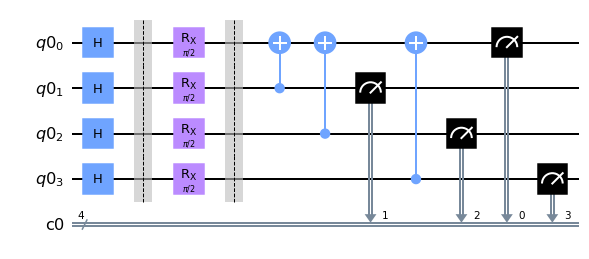

In [3]:
def pcircuit(nqubits, depth = 10):
    """ Circuit to test performance of quantum computer """
    q = QuantumRegister(nqubits)
    ans = ClassicalRegister(nqubits)
    qc = QuantumCircuit(q, ans)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()

        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
    for qidx in range(nqubits):
        qc.measure(q[qidx], ans[qidx])
    return q, qc

q,qc = pcircuit(4, 1)
qc.draw(output='mpl')

## Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [4]:
token = load_account()
if token is not None:
    authentication = get_token_authentication(token)
else:
    if QI_EMAIL is None or QI_PASSWORD is None:
        print('Enter email')
        email = input()
        print('Enter password')
        password = getpass()
    else:
        email, password = QI_EMAIL, QI_PASSWORD
    authentication = get_basic_authentication(email, password)

QI.set_authentication(authentication, QI_URL)

We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [5]:
qi_backend = QI.get_backend('QX single-node simulator')
job = execute(qc, qi_backend)

We can wait for the results and then print them

In [6]:
result = job.result()
print('Generated histogram:')
print(result.get_counts())

Generated histogram:
{'0000': 63, '0001': 68, '0010': 62, '0011': 52, '0100': 59, '0101': 69, '0110': 72, '0111': 64, '1000': 72, '1001': 65, '1010': 58, '1011': 72, '1100': 64, '1101': 64, '1110': 68, '1111': 52}


Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

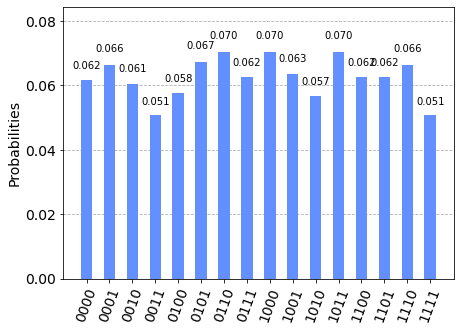

In [7]:
plot_histogram(result.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* QisKit: 3.7 seconds
* ProjectQ: 2.0 seconds

Our simulator runs for multiple shots (unless full state projection is used). More details will follow later.

In [8]:
q, qc = pcircuit(10, 10)
start_time = time.time()

job = execute(qc, qi_backend, shots=8)
job.result()
interval = time.time() - start_time

print('time needed: %.1f [s]' % (interval,))

time needed: 5.6 [s]
